# Task 1: Unconditional generation

In [247]:
%matplotlib inline
import matplotlib
import sys 

sys.path.insert(0,'..')
from utils import plot_stroke

In [248]:
import numpy as np
strokes = np.load('../data/strokes-py3.npy', allow_pickle=True)

In [276]:
# Due to time constraint, will not train for the whole dataset
import math
training = strokes[:math.floor(len(strokes)*0.05)]
len(training)

300

In [279]:
# Normalize training co-ordinate offsets
x_mean, y_mean, count = 0, 0, 0

for stroke in training:
    for i in stroke:
        x_mean += i[1]
        y_mean += i[2]
        count += 1
x_mean /= count
y_mean /= count

In [280]:
std_x, std_y = 0, 0
for stroke in training:
    for i in stroke:
        std_x += (i[1]-x_mean)**2
        std_y += (i[2]-y_mean)**2
std_x /= count
std_y /= count
std_x = std_x**(0.5)
std_y = std_y**(0.5)

In [281]:
for stroke in training:
    for i in stroke:
        i[1] = (i[1]-x_mean)/std_x
        i[2] = (i[2]-y_mean)/std_y

In [275]:
# Prepare training data as X and y.
# Each sample of X is of shape (400,3) and each sample of y is of shape (1,3)
# i.e. use the first 400 strokes to predict the last one
X = []
y = []
for sample in training:
    for i in range(len(sample)-400-2):
        X.append(sample[i:i+400])
        y.append(sample[i+400+1])
X = np.array(X)
y = np.array(y)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (75636, 400, 3)
Shape of y: (75636, 3)


In [473]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Input
from tensorflow.keras.models import Model
import mdn

In [284]:
keras.backend.clear_session()

inputs = Input(shape=(400,3))
x = LSTM(256, return_sequences=True,batch_input_shape = (None,400,3))(inputs)
x = LSTM(256)(x)
outputs = mdn.MDN(3, 10)(x)
model = Model(inputs=inputs,outputs=outputs)
model.compile(loss=mdn.get_mixture_loss_func(3,10), optimizer=keras.optimizers.Adam())

# Fit the model
history = model.fit(X, y, batch_size=128, epochs=10, validation_split = 0.2)

Train on 60508 samples, validate on 15128 samples
Epoch 1/10
60508/60508 [==============================] - 1332s 22ms/sample - loss: 2.7304 - val_loss: 3.0756
Epoch 2/10
60508/60508 [==============================] - 1368s 23ms/sample - loss: 2.5644 - val_loss: 4.0500
Epoch 3/10
60508/60508 [==============================] - 1397s 23ms/sample - loss: 1.4783 - val_loss: 17.2502
Epoch 4/10
60508/60508 [==============================] - 1367s 23ms/sample - loss: 1.3815 - val_loss: 4.4714
Epoch 5/10
60508/60508 [==============================] - 1451s 24ms/sample - loss: 0.3586 - val_loss: 1.4932
Epoch 6/10
60508/60508 [==============================] - 1395s 23ms/sample - loss: -0.6228 - val_loss: -2.9106
Epoch 7/10
60508/60508 [==============================] - 1351s 22ms/sample - loss: 0.8578 - val_loss: -0.0016
Epoch 8/10
60508/60508 [==============================] - 1395s 23ms/sample - loss: -0.4225 - val_loss: -0.2358
Epoch 9/10
60508/60508 [==============================] - 1341s 

In [285]:
model.save_weights('model_weights.h5')

In [286]:
# Set up the generator
inputs = Input(shape=(1,3))
x = LSTM(256, return_sequences=True,batch_input_shape = (1,1,3))(inputs)
x = LSTM(256)(x)
outputs = mdn.MDN(3, 10)(x)
generator = Model(inputs=inputs,outputs=outputs)

generator.compile(loss=mdn.get_mixture_loss_func(3,10), optimizer=keras.optimizers.Adam())
generator.summary()

generator.load_weights('model_weights.h5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 3)]            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 256)            266240    
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
mdn_1 (MDN)                  (None, 70)                17990     
Total params: 809,542
Trainable params: 809,542
Non-trainable params: 0
_________________________________________________________________


In [343]:
predictions = []
stroke_pt = np.asarray([1,0,0], dtype=np.float32) # start point
predictions.append(stroke_pt)

for i in range(400):
    stroke_pt = mdn.sample_from_output(generator.predict(stroke_pt.reshape(1,1,3))[0], 3, 10)
    predictions.append(stroke_pt.reshape((3,)))

predictions = np.array(predictions, dtype=np.float32)
for i in range(len(predictions)):
    predictions[i][0] = (predictions[i][0] > 0.5)*1
    predictions[i][1] = predictions[i][1] * std_x + x_mean
    predictions[i][2] = predictions[i][2] * std_y + y_mean

In [344]:
predictions

array([[ 1.0000000e+00,  1.3753500e-10,  1.2982443e-10],
       [ 1.0000000e+00,  5.1755529e-02,  4.4019455e-01],
       [ 0.0000000e+00, -3.3939913e-01,  2.0617759e+00],
       ...,
       [ 0.0000000e+00, -4.8726149e-02, -4.2443607e-02],
       [ 0.0000000e+00,  2.8220761e+00,  5.1552159e-01],
       [ 1.0000000e+00, -7.8888372e-02, -4.2698953e-01]], dtype=float32)

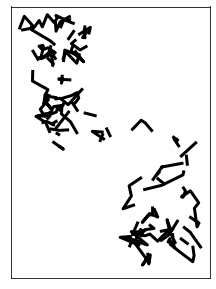

In [345]:
plot_stroke(predictions)